In [5]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [6]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 2

In [7]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [8]:
tol = 1e-7
ϵ = .1
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o


def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [9]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 0.1, 1000, 0.1)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 1000: PDE Error: 0.022900233439; False Transient Error: 0.022586806231; Iterations: 119; CG Error: 0.000000000100
Episode 1000: PDE Error: 0.021253377408; False Transient Error: 0.020978846295; Iterations: 120; CG Error: 0.000000000089
Episode 1000: PDE Error: 0.026850468708; False Transient Error: 0.024606497956; Iterations: 119; CG Error: 0.000000000096
Episode 1000: PDE Error: 0.020323340652; False Transient Error: 0.020071833715; Iterations: 119; CG Error: 0.000000000100
Episode 1000: PDE Error: 0.013727822080; False Transient Error: 0.013695544164; Iterations: 116; CG Error: 0.000000000089
Episode 1000: PDE Error: 0.029770685149; False Transient Error: 0.025756467753; Iterations: 119; CG Error: 0.000000000094
Episode 1000: PDE Error: 0.013923546269; False Transient Error: 0.013849451083; Iterations: 118; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.015190121524; False Transient Error: 0.015159519362; Iterations: 110; CG Error: 0.000000000091
Episode 1000: PDE Error:

In [10]:
np.save("v_list_2", ϕ_list)
np.save("e_list_2", ems_list)

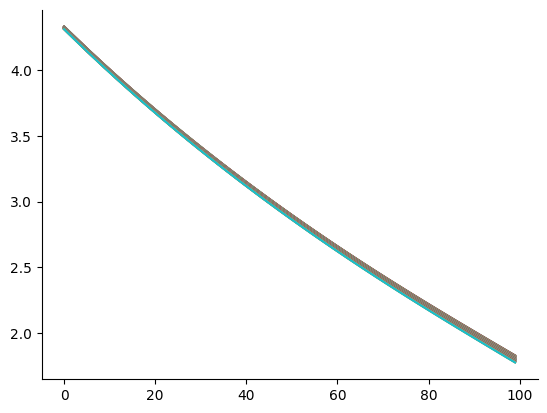

In [11]:
loc_start = np.abs(y2_grid - np.mean(θ_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(θ_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(θ_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

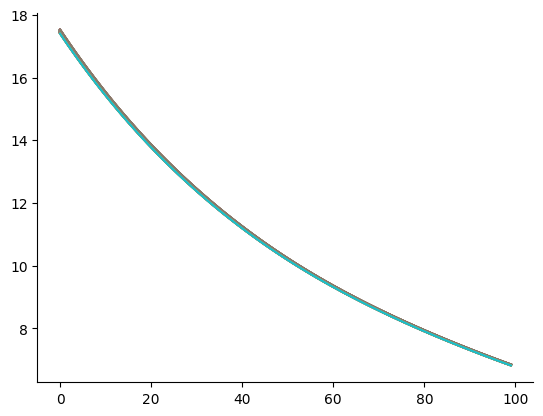

In [12]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [13]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.1
max_iter = 2000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.475550366801	 rhs error: 0.481124530190
Episode: 2	 lhs error: 0.463350206003	 rhs error: 0.468298402887
Episode: 3	 lhs error: 0.444906575089	 rhs error: 0.449350176176
Episode: 4	 lhs error: 0.424283703530	 rhs error: 0.428151237859
Episode: 5	 lhs error: 0.402384281155	 rhs error: 0.406213183922
Episode: 6	 lhs error: 0.381614650640	 rhs error: 0.384263908061
Episode: 7	 lhs error: 0.359764821147	 rhs error: 0.362546590955
Episode: 8	 lhs error: 0.339790257365	 rhs error: 0.341457135929
Episode: 9	 lhs error: 0.319166018873	 rhs error: 0.320921706589
Episode: 10	 lhs error: 0.300219625498	 rhs error: 0.301233451423
Episode: 11	 lhs error: 0.281607399420	 rhs error: 0.282247010136
Episode: 12	 lhs error: 0.263691990437	 rhs error: 0.264114397133
Episode: 13	 lhs error: 0.246573880465	 rhs error: 0.246805623257
Episode: 14	 lhs error: 0.230227694328	 rhs error: 0.230361981283
Episode: 15	 lhs error: 0.214292275011	 rhs error: 0.214846725912
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.035350010996	 rhs error: 0.100445840000
Episode: 126	 lhs error: 0.035109995374	 rhs error: 0.100667405926
Episode: 127	 lhs error: 0.034871680686	 rhs error: 0.100880614942
Episode: 128	 lhs error: 0.034755609556	 rhs error: 0.101088216038
Episode: 129	 lhs error: 0.034654120179	 rhs error: 0.101291305019
Episode: 130	 lhs error: 0.034554749258	 rhs error: 0.101489902489
Episode: 131	 lhs error: 0.034405810187	 rhs error: 0.101684055498
Episode: 132	 lhs error: 0.034374974879	 rhs error: 0.101832016528
Episode: 133	 lhs error: 0.034266538588	 rhs error: 0.102039978977
Episode: 134	 lhs error: 0.034097528564	 rhs error: 0.102228968220
Episode: 135	 lhs error: 0.034081215882	 rhs error: 0.102362083769
Episode: 136	 lhs error: 0.033965989838	 rhs error: 0.102554280803
Episode: 137	 lhs error: 0.033785121161	 rhs error: 0.102725127893
Episode: 138	 lhs error: 0.033778684266	 rhs error: 0.102839847670
Episode: 139	 lhs error: 0.033570195310	 rhs error: 0.10301601

Episode: 249	 lhs error: 0.023855094770	 rhs error: 0.101107846670
Episode: 250	 lhs error: 0.023729732488	 rhs error: 0.100995770894
Episode: 251	 lhs error: 0.023662818437	 rhs error: 0.100765750066
Episode: 252	 lhs error: 0.023543258855	 rhs error: 0.100634717565
Episode: 253	 lhs error: 0.023542353870	 rhs error: 0.100392262311
Episode: 254	 lhs error: 0.023492722666	 rhs error: 0.100242802151
Episode: 255	 lhs error: 0.023490521524	 rhs error: 0.099987745274
Episode: 256	 lhs error: 0.023440376309	 rhs error: 0.099820272365
Episode: 257	 lhs error: 0.023435389194	 rhs error: 0.099552558873
Episode: 258	 lhs error: 0.023384864336	 rhs error: 0.099367307899
Episode: 259	 lhs error: 0.023376804409	 rhs error: 0.099086988491
Episode: 260	 lhs error: 0.023326131626	 rhs error: 0.098883836156
Episode: 261	 lhs error: 0.023314379112	 rhs error: 0.098591022246
Episode: 262	 lhs error: 0.023295855396	 rhs error: 0.098368925334
Episode: 263	 lhs error: 0.023245406978	 rhs error: 0.09811707

Episode: 373	 lhs error: 0.018224362635	 rhs error: 0.054054127716
Episode: 374	 lhs error: 0.018199578531	 rhs error: 0.053769328987
Episode: 375	 lhs error: 0.018132860545	 rhs error: 0.053494253212
Episode: 376	 lhs error: 0.018094747607	 rhs error: 0.053196636993
Episode: 377	 lhs error: 0.018094701638	 rhs error: 0.052874862739
Episode: 378	 lhs error: 0.018063426578	 rhs error: 0.052604786985
Episode: 379	 lhs error: 0.018035015032	 rhs error: 0.052319675293
Episode: 380	 lhs error: 0.018022511186	 rhs error: 0.051986301834
Episode: 381	 lhs error: 0.018003933740	 rhs error: 0.051705571497
Episode: 382	 lhs error: 0.017987208330	 rhs error: 0.051396988579
Episode: 383	 lhs error: 0.017960268021	 rhs error: 0.051094784844
Episode: 384	 lhs error: 0.017941904107	 rhs error: 0.050781189301
Episode: 385	 lhs error: 0.017910207008	 rhs error: 0.050478260634
Episode: 386	 lhs error: 0.017905493681	 rhs error: 0.050161137333
Episode: 387	 lhs error: 0.017879553270	 rhs error: 0.04984637

Episode: 497	 lhs error: 0.014658508437	 rhs error: 0.025361615377
Episode: 498	 lhs error: 0.014616890427	 rhs error: 0.025266726427
Episode: 499	 lhs error: 0.014602503105	 rhs error: 0.025189453795
Episode: 500	 lhs error: 0.014603694673	 rhs error: 0.025105905152
Episode: 501	 lhs error: 0.014552718246	 rhs error: 0.025051882376
Episode: 502	 lhs error: 0.014530832754	 rhs error: 0.024983203908
Episode: 503	 lhs error: 0.014508826316	 rhs error: 0.024912839267
Episode: 504	 lhs error: 0.014484025502	 rhs error: 0.024846065060
Episode: 505	 lhs error: 0.014484860449	 rhs error: 0.024782471747
Episode: 506	 lhs error: 0.014446561475	 rhs error: 0.024729714027
Episode: 507	 lhs error: 0.014432491388	 rhs error: 0.024659010093
Episode: 508	 lhs error: 0.014399670479	 rhs error: 0.024622352016
Episode: 509	 lhs error: 0.014367391694	 rhs error: 0.024590162271
Episode: 510	 lhs error: 0.014370321734	 rhs error: 0.024513615377
Episode: 511	 lhs error: 0.014314570365	 rhs error: 0.02447257

Episode: 621	 lhs error: 0.011910832179	 rhs error: 0.024257559640
Episode: 622	 lhs error: 0.011901986559	 rhs error: 0.024248480614
Episode: 623	 lhs error: 0.011903892889	 rhs error: 0.024249332965
Episode: 624	 lhs error: 0.011872221984	 rhs error: 0.024258433192
Episode: 625	 lhs error: 0.011862794954	 rhs error: 0.024249069560
Episode: 626	 lhs error: 0.011867566740	 rhs error: 0.024248607794
Episode: 627	 lhs error: 0.011832544248	 rhs error: 0.024259619473
Episode: 628	 lhs error: 0.011823024718	 rhs error: 0.024250669898
Episode: 629	 lhs error: 0.011825234968	 rhs error: 0.024250945267
Episode: 630	 lhs error: 0.011789899623	 rhs error: 0.024260988026
Episode: 631	 lhs error: 0.011779301547	 rhs error: 0.024251680503
Episode: 632	 lhs error: 0.011779503283	 rhs error: 0.024251772521
Episode: 633	 lhs error: 0.011745086894	 rhs error: 0.024260723727
Episode: 634	 lhs error: 0.011732474268	 rhs error: 0.024252208563
Episode: 635	 lhs error: 0.011720218275	 rhs error: 0.02425065

Episode: 745	 lhs error: 0.009935932113	 rhs error: 0.024244565530
Episode: 746	 lhs error: 0.009915768963	 rhs error: 0.024248638400
Episode: 747	 lhs error: 0.009907787712	 rhs error: 0.024230301710
Episode: 748	 lhs error: 0.009895453680	 rhs error: 0.024239055655
Episode: 749	 lhs error: 0.009885799927	 rhs error: 0.024233077147
Episode: 750	 lhs error: 0.009876162276	 rhs error: 0.024234823980
Episode: 751	 lhs error: 0.009870697623	 rhs error: 0.024240177307
Episode: 752	 lhs error: 0.009849435130	 rhs error: 0.024243208519
Episode: 753	 lhs error: 0.009840378092	 rhs error: 0.024226239059
Episode: 754	 lhs error: 0.009827453759	 rhs error: 0.024234399171
Episode: 755	 lhs error: 0.009816606667	 rhs error: 0.024231070812
Episode: 756	 lhs error: 0.009804319898	 rhs error: 0.024234157119
Episode: 757	 lhs error: 0.009789665125	 rhs error: 0.024234614029
Episode: 758	 lhs error: 0.009779694083	 rhs error: 0.024224191886
Episode: 759	 lhs error: 0.009767290555	 rhs error: 0.02423220

Episode: 869	 lhs error: 0.008389002759	 rhs error: 0.024247662190
Episode: 870	 lhs error: 0.008376830228	 rhs error: 0.024257280794
Episode: 871	 lhs error: 0.008365751420	 rhs error: 0.024269484933
Episode: 872	 lhs error: 0.008355406899	 rhs error: 0.024248850596
Episode: 873	 lhs error: 0.008344100726	 rhs error: 0.024259950776
Episode: 874	 lhs error: 0.008332869672	 rhs error: 0.024253657217
Episode: 875	 lhs error: 0.008321088327	 rhs error: 0.024260402505
Episode: 876	 lhs error: 0.008309280073	 rhs error: 0.024257477854
Episode: 877	 lhs error: 0.008297097921	 rhs error: 0.024261426545
Episode: 878	 lhs error: 0.008285154523	 rhs error: 0.024263449292
Episode: 879	 lhs error: 0.008273268029	 rhs error: 0.024251324307
Episode: 880	 lhs error: 0.008260503353	 rhs error: 0.024257912385
Episode: 881	 lhs error: 0.008247883492	 rhs error: 0.024262720091
Episode: 882	 lhs error: 0.008235294856	 rhs error: 0.024256406165
Episode: 883	 lhs error: 0.008222198579	 rhs error: 0.02425979

Episode: 993	 lhs error: 0.007124351034	 rhs error: 0.024229065672
Episode: 994	 lhs error: 0.007116135596	 rhs error: 0.024229317765
Episode: 995	 lhs error: 0.007107907197	 rhs error: 0.024229579297
Episode: 996	 lhs error: 0.007099511746	 rhs error: 0.024229961883
Episode: 997	 lhs error: 0.007090973353	 rhs error: 0.024230158103
Episode: 998	 lhs error: 0.007082346970	 rhs error: 0.024230447594
Episode: 999	 lhs error: 0.007057463664	 rhs error: 0.024230004565
Episode: 1000	 lhs error: 0.007050749383	 rhs error: 0.024212074354
Episode: 1001	 lhs error: 0.007040513318	 rhs error: 0.024299113192
Episode: 1002	 lhs error: 0.007031537808	 rhs error: 0.024231249913
Episode: 1003	 lhs error: 0.007019512273	 rhs error: 0.024183107411
Episode: 1004	 lhs error: 0.007018728116	 rhs error: 0.024208869594
Episode: 1005	 lhs error: 0.007004703593	 rhs error: 0.024295744655
Episode: 1006	 lhs error: 0.006990804011	 rhs error: 0.024457176814
Episode: 1007	 lhs error: 0.006982046641	 rhs error: 0.

Episode: 1117	 lhs error: 0.006090302648	 rhs error: 0.024266237495
Episode: 1118	 lhs error: 0.006082638428	 rhs error: 0.024266122135
Episode: 1119	 lhs error: 0.006075052548	 rhs error: 0.024266541782
Episode: 1120	 lhs error: 0.006067232665	 rhs error: 0.024266659219
Episode: 1121	 lhs error: 0.006059578734	 rhs error: 0.024266918017
Episode: 1122	 lhs error: 0.006051496775	 rhs error: 0.024266661423
Episode: 1123	 lhs error: 0.006043703966	 rhs error: 0.024266959627
Episode: 1124	 lhs error: 0.006035562386	 rhs error: 0.024266569372
Episode: 1125	 lhs error: 0.006027253764	 rhs error: 0.024266686080
Episode: 1126	 lhs error: 0.006018835599	 rhs error: 0.024266798010
Episode: 1127	 lhs error: 0.006010357253	 rhs error: 0.024266889712
Episode: 1128	 lhs error: 0.006002061877	 rhs error: 0.024266947471
Episode: 1129	 lhs error: 0.005993461294	 rhs error: 0.024266646018
Episode: 1130	 lhs error: 0.005984910071	 rhs error: 0.024266599128
Episode: 1131	 lhs error: 0.005976191792	 rhs er

Episode: 1241	 lhs error: 0.005198029020	 rhs error: 0.024336809789
Episode: 1242	 lhs error: 0.005208377658	 rhs error: 0.024342160594
Episode: 1243	 lhs error: 0.005188972672	 rhs error: 0.024326543042
Episode: 1244	 lhs error: 0.005181034749	 rhs error: 0.024337239074
Episode: 1245	 lhs error: 0.005190623380	 rhs error: 0.024342610230
Episode: 1246	 lhs error: 0.005171661691	 rhs error: 0.024327117506
Episode: 1247	 lhs error: 0.005163415391	 rhs error: 0.024337956798
Episode: 1248	 lhs error: 0.005155640821	 rhs error: 0.024343388143
Episode: 1249	 lhs error: 0.005165753073	 rhs error: 0.024347302510
Episode: 1250	 lhs error: 0.005146897419	 rhs error: 0.024331176662
Episode: 1251	 lhs error: 0.005138250253	 rhs error: 0.024341798816
Episode: 1252	 lhs error: 0.005130251630	 rhs error: 0.024346961319
Episode: 1253	 lhs error: 0.005139781350	 rhs error: 0.024350662534
Episode: 1254	 lhs error: 0.005121083783	 rhs error: 0.024334161413
Episode: 1255	 lhs error: 0.005112072029	 rhs er

Episode: 1365	 lhs error: 0.004479728164	 rhs error: 0.024301933969
Episode: 1366	 lhs error: 0.004537677648	 rhs error: 0.024271622125
Episode: 1367	 lhs error: 0.004468172684	 rhs error: 0.024299215126
Episode: 1368	 lhs error: 0.004471139466	 rhs error: 0.024266745650
Episode: 1369	 lhs error: 0.004518217907	 rhs error: 0.024265626231
Episode: 1370	 lhs error: 0.004451524124	 rhs error: 0.024292919660
Episode: 1371	 lhs error: 0.004508447370	 rhs error: 0.024264588816
Episode: 1372	 lhs error: 0.004439613444	 rhs error: 0.024290233379
Episode: 1373	 lhs error: 0.004497819596	 rhs error: 0.024260816189
Episode: 1374	 lhs error: 0.004426926229	 rhs error: 0.024286493931
Episode: 1375	 lhs error: 0.004488787398	 rhs error: 0.024257042852
Episode: 1376	 lhs error: 0.004414804008	 rhs error: 0.024282657192
Episode: 1377	 lhs error: 0.004420203540	 rhs error: 0.024252544588
Episode: 1378	 lhs error: 0.004471331138	 rhs error: 0.024252584137
Episode: 1379	 lhs error: 0.004401073011	 rhs er

Episode: 1489	 lhs error: 0.003953083999	 rhs error: 0.024180573059
Episode: 1490	 lhs error: 0.003926238026	 rhs error: 0.024155165391
Episode: 1491	 lhs error: 0.003953820091	 rhs error: 0.024144229533
Episode: 1492	 lhs error: 0.004069275649	 rhs error: 0.024106970759
Episode: 1493	 lhs error: 0.003931853413	 rhs error: 0.024173396276
Episode: 1494	 lhs error: 0.003911473906	 rhs error: 0.024152267313
Episode: 1495	 lhs error: 0.003904305012	 rhs error: 0.024146509514
Episode: 1496	 lhs error: 0.003897628346	 rhs error: 0.024142981195
Episode: 1497	 lhs error: 0.003891691956	 rhs error: 0.024140115850
Episode: 1498	 lhs error: 0.003888196139	 rhs error: 0.024137015837
Episode: 1499	 lhs error: 0.003915007509	 rhs error: 0.024131426087
Episode: 1500	 lhs error: 0.003878855569	 rhs error: 0.024141452466
Episode: 1501	 lhs error: 0.003872796039	 rhs error: 0.024144029325
Episode: 1502	 lhs error: 0.003867679955	 rhs error: 0.024143683703
Episode: 1503	 lhs error: 0.003862073517	 rhs er

Episode: 1613	 lhs error: 0.002965973817	 rhs error: 0.024184549646
Episode: 1614	 lhs error: 0.002955589047	 rhs error: 0.024185922535
Episode: 1615	 lhs error: 0.002945165738	 rhs error: 0.024187287071
Episode: 1616	 lhs error: 0.002934705093	 rhs error: 0.024188639225
Episode: 1617	 lhs error: 0.002924208104	 rhs error: 0.024189976230
Episode: 1618	 lhs error: 0.002913675623	 rhs error: 0.024191296001
Episode: 1619	 lhs error: 0.002903108603	 rhs error: 0.024192596984
Episode: 1620	 lhs error: 0.002892508007	 rhs error: 0.024193878019
Episode: 1621	 lhs error: 0.002881874432	 rhs error: 0.024195138561
Episode: 1622	 lhs error: 0.002871208842	 rhs error: 0.024196377821
Episode: 1623	 lhs error: 0.002860511887	 rhs error: 0.024197595645
Episode: 1624	 lhs error: 0.002849784175	 rhs error: 0.024198791915
Episode: 1625	 lhs error: 0.002839026513	 rhs error: 0.024199966505
Episode: 1626	 lhs error: 0.002828239447	 rhs error: 0.024201119398
Episode: 1627	 lhs error: 0.002833850367	 rhs er

Episode: 1737	 lhs error: 0.001609005694	 rhs error: 0.024221913864
Episode: 1738	 lhs error: 0.001598495070	 rhs error: 0.024220043324
Episode: 1739	 lhs error: 0.001588011856	 rhs error: 0.024218422610
Episode: 1740	 lhs error: 0.001577505613	 rhs error: 0.024216880257
Episode: 1741	 lhs error: 0.001567082828	 rhs error: 0.024215643781
Episode: 1742	 lhs error: 0.001579047105	 rhs error: 0.024214451844
Episode: 1743	 lhs error: 0.001564799755	 rhs error: 0.024140693602
Episode: 1744	 lhs error: 0.001552022629	 rhs error: 0.024120367433
Episode: 1745	 lhs error: 0.001522979558	 rhs error: 0.024197894739
Episode: 1746	 lhs error: 0.001513236758	 rhs error: 0.024208592141
Episode: 1747	 lhs error: 0.001502757953	 rhs error: 0.024208296679
Episode: 1748	 lhs error: 0.001492459560	 rhs error: 0.024207098832
Episode: 1749	 lhs error: 0.001508257240	 rhs error: 0.024206992157
Episode: 1750	 lhs error: 0.001469169009	 rhs error: 0.024150359249
Episode: 1751	 lhs error: 0.001462907171	 rhs er

Episode: 1861	 lhs error: 0.000598225161	 rhs error: 0.024260802896
Episode: 1862	 lhs error: 0.000590746744	 rhs error: 0.024261293305
Episode: 1863	 lhs error: 0.000587168804	 rhs error: 0.024260155997
Episode: 1864	 lhs error: 0.000583202787	 rhs error: 0.024261604871
Episode: 1865	 lhs error: 0.000580352869	 rhs error: 0.024262064867
Episode: 1866	 lhs error: 0.000574504211	 rhs error: 0.024260946030
Episode: 1867	 lhs error: 0.000571610440	 rhs error: 0.024261508218
Episode: 1868	 lhs error: 0.000568164882	 rhs error: 0.024261166390
Episode: 1869	 lhs error: 0.000564525404	 rhs error: 0.024261319200
Episode: 1870	 lhs error: 0.000559606910	 rhs error: 0.024261025643
Episode: 1871	 lhs error: 0.000558219932	 rhs error: 0.024260273625
Episode: 1872	 lhs error: 0.000553489800	 rhs error: 0.024259689230
Episode: 1873	 lhs error: 0.000550252110	 rhs error: 0.024259070064
Episode: 1874	 lhs error: 0.000546838465	 rhs error: 0.024258051787
Episode: 1875	 lhs error: 0.000543654800	 rhs er

Episode: 1985	 lhs error: 0.000198244676	 rhs error: 0.024265211192
Episode: 1986	 lhs error: 0.000152256726	 rhs error: 0.024260523673
Episode: 1987	 lhs error: 0.000146302721	 rhs error: 0.024261629203
Episode: 1988	 lhs error: 0.000144835059	 rhs error: 0.024263251501
Episode: 1989	 lhs error: 0.000143412688	 rhs error: 0.024264764236
Episode: 1990	 lhs error: 0.000613123166	 rhs error: 0.024266782061
Episode: 1991	 lhs error: 0.000499073875	 rhs error: 0.024306654531
Episode: 1992	 lhs error: 0.000538647341	 rhs error: 0.024302322917
Episode: 1993	 lhs error: 0.000339611840	 rhs error: 0.024302595120
Episode: 1994	 lhs error: 0.000237545874	 rhs error: 0.024263111629
Episode: 1995	 lhs error: 0.000187162628	 rhs error: 0.024260168828
Episode: 1996	 lhs error: 0.000156483203	 rhs error: 0.024261478482
Episode: 1997	 lhs error: 0.000133738145	 rhs error: 0.024263071263
Episode: 1998	 lhs error: 0.000128094656	 rhs error: 0.024264497018
Episode: 1999	 lhs error: 0.000126897343	 rhs er

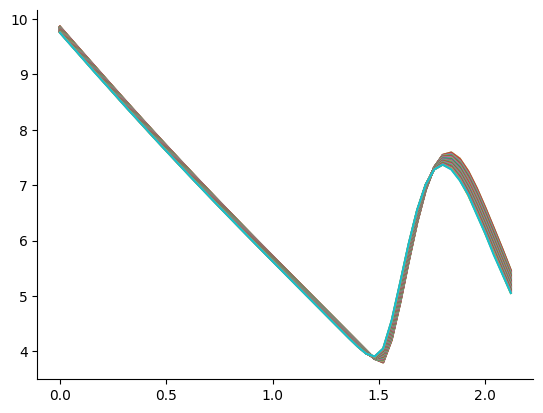

In [14]:
plt.plot(y1_grid_cap, ems)
plt.show()

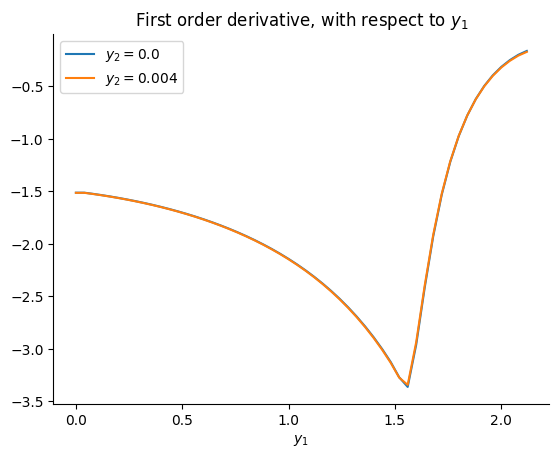

In [15]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

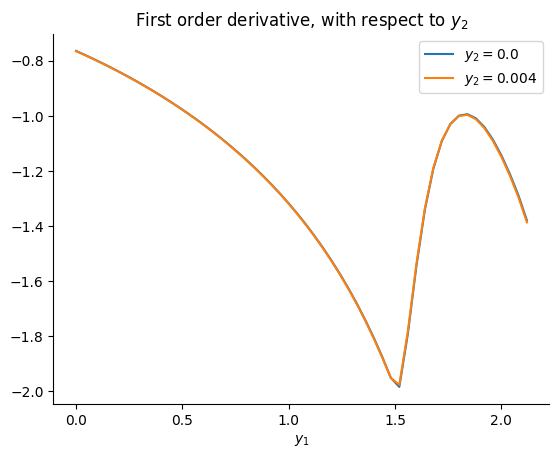

In [16]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

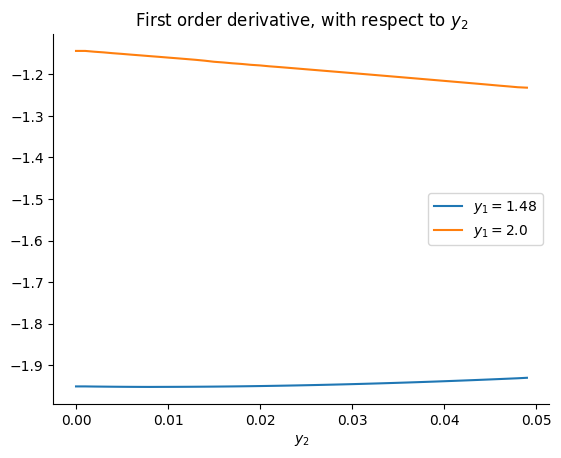

In [17]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

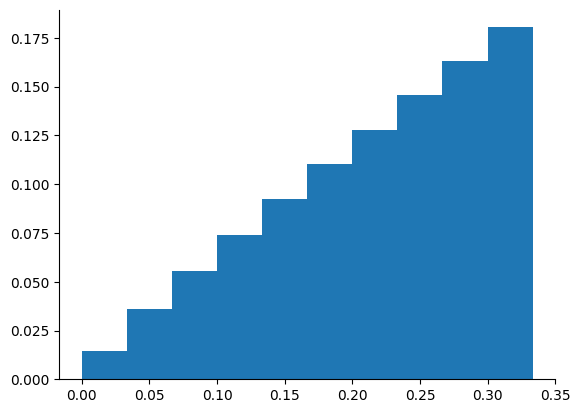

In [18]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

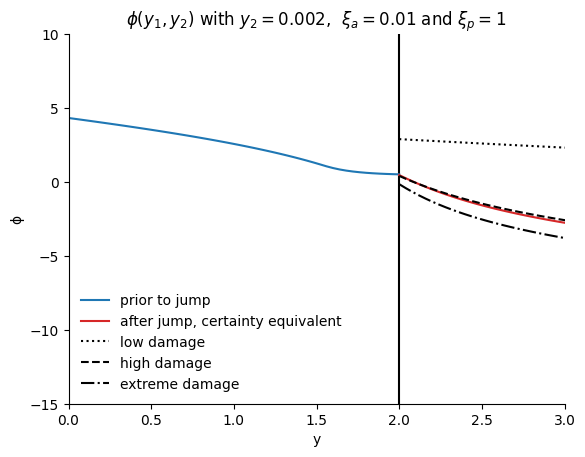

In [19]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

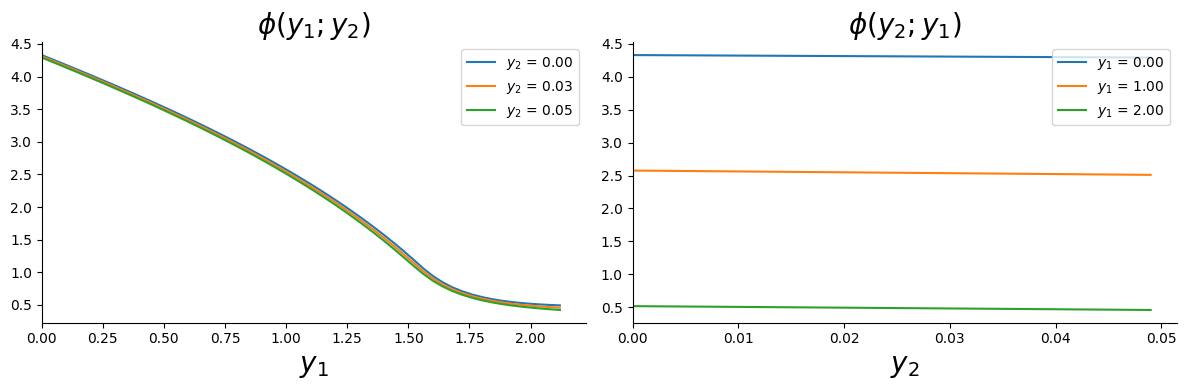

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

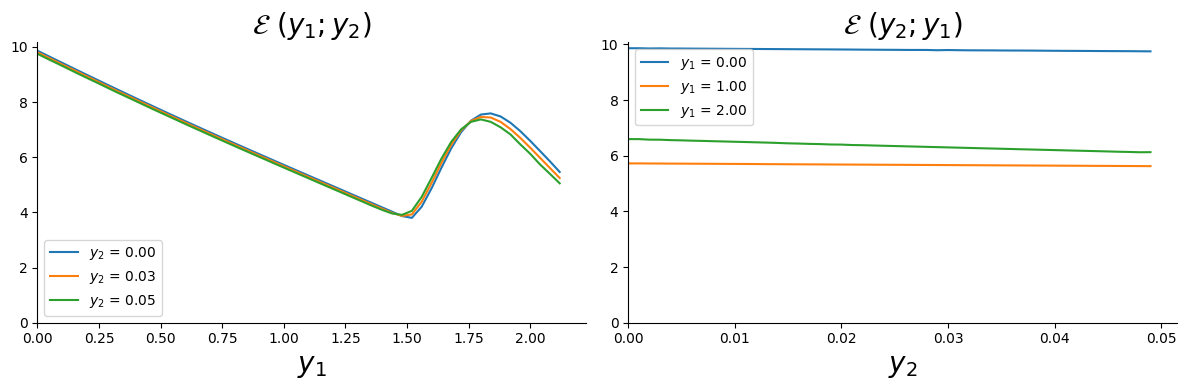

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [22]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [23]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [24]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [25]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [26]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

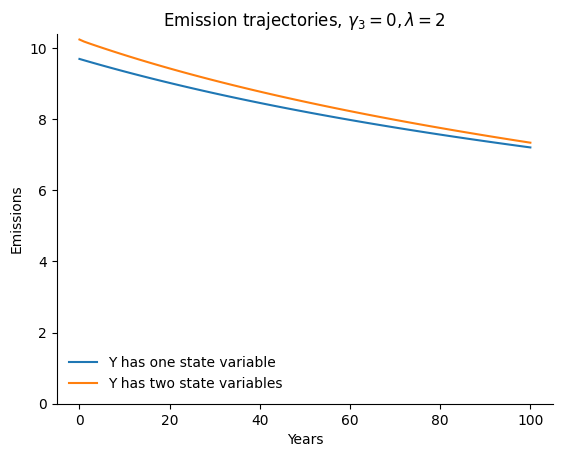

In [27]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [28]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=93
                                                 )

In [39]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open("simul_2", "wb"))

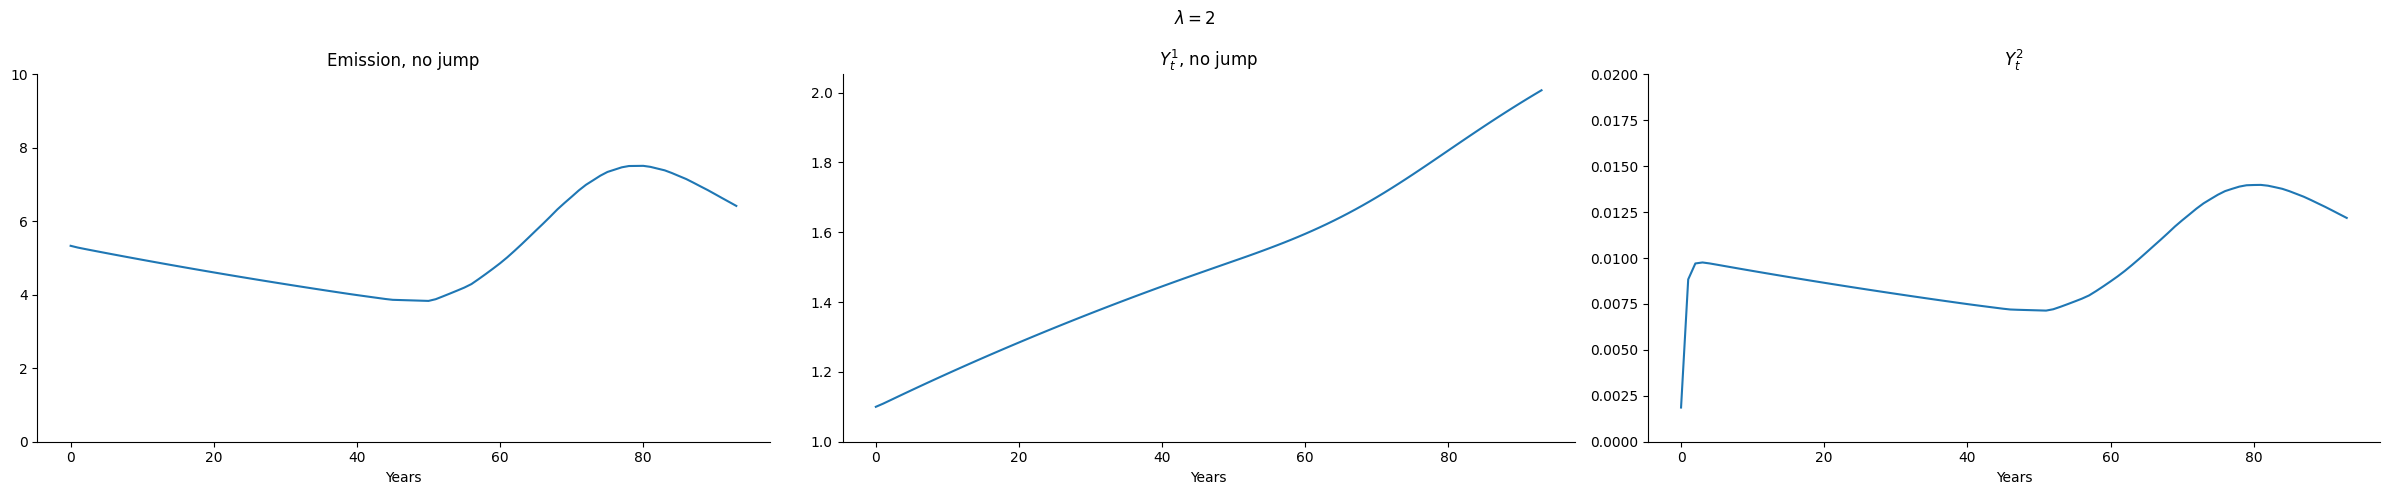

In [55]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [56]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

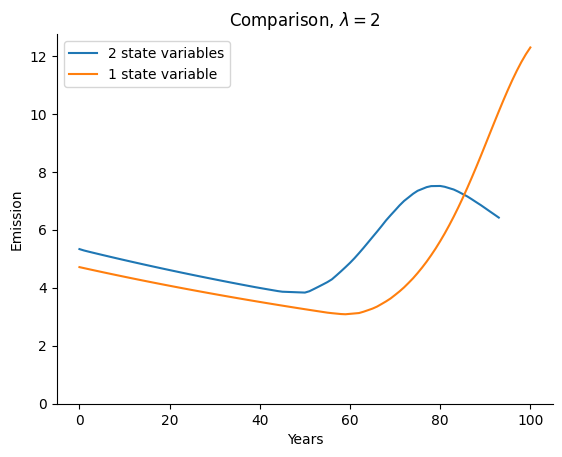

In [58]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [59]:

# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [60]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [61]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=94)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

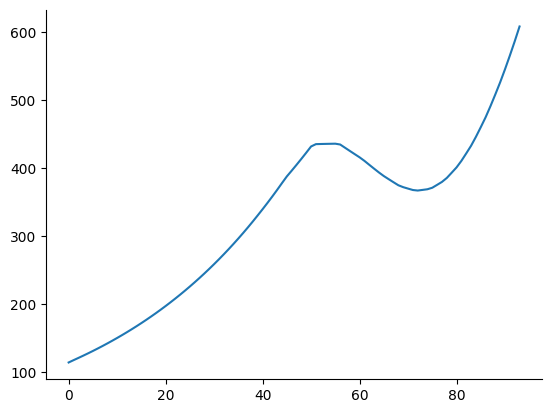

In [62]:
plt.plot(scc)
plt.show()

In [63]:
np.save(f"scct_{λ}", scc)